In [1]:
import matplotlib.pyplot as plt
import ni_nileUtils
%matplotlib inline

# plot annual mean temp across all historical models

[tempHistorical, models] = ni_nileUtils.readModelData('data/r1-temp-rcp45.csv')
tempHistorical[models[-1]][-1]

19.034216000000001

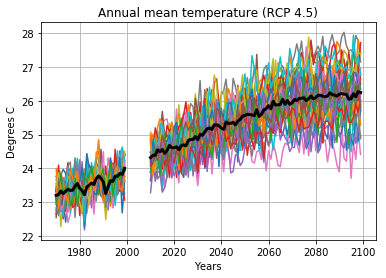

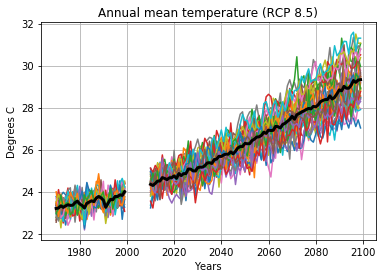

In [202]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot annual mean temp across all historical models

def plotAnnualMean(data, title):
    # get all unique years
    years = numpy.unique(data['Year'])

    annMean = []

    # for all models
    for model in models:
        if model == 'Actual': continue
            
        curAnnMean = []
        for year in years:
            # find indices for current year
            ind = numpy.where(data['Year'] == year)

            # take mean across all months if possible, otherwise set to nan
            try:
                curAnnMean.append(numpy.nanmean(data[model][ind]))
            except:
                curAnnMean.append(numpy.nan)
        
        # store and plot current year/model's list of annual means
        annMean.append(curAnnMean)
        plt.plot(years, curAnnMean)
    
    # convert to numpy array and take multi-model mean
    annMean = numpy.array(annMean)
    multiModelMean = numpy.nanmean(annMean, axis=0)

    plt.plot(years, multiModelMean, 'k-', linewidth=3)
    plt.xlabel('Years')
    plt.ylabel('Degrees C')
    plt.title(title)


[tempHistorical, models] = readModelData('data/r1-temp-historical.csv')
[tempRcp45, models] = readModelData('data/r1-temp-rcp45.csv')
[tempRcp85, models] = readModelData('data/r1-temp-rcp85.csv')

# plot historical and RCP 4.5/RCP 8.5
plt.figure(0)
plt.grid()
plotAnnualMean(tempHistorical, 'Annual mean temperature (historical)')
plotAnnualMean(tempRcp45, 'Annual mean temperature (RCP 4.5)')
plt.savefig('temp-rcp45.png', dpi=600)

plt.figure(1)
plt.grid()
plotAnnualMean(tempHistorical, 'Annual mean temperature (historical)')
plotAnnualMean(tempRcp85, 'Annual mean temperature (RCP 8.5)')
plt.savefig('temp-rcp85.png', dpi=600)

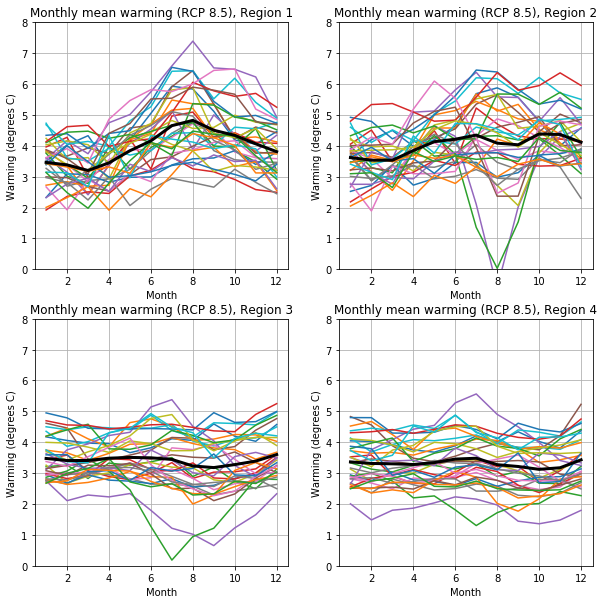

In [6]:
# plot seasonal temp change

import matplotlib.pyplot as plt
import numpy
import ni_nileUtils
%matplotlib inline

def calcMonthlyMeanChg(past, future):
    [tempHistorical, models] = ni_nileUtils.readModelData(past)
    [tempRcp85, models] = ni_nileUtils.readModelData(future)

    months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    futurePeriod = [2060, 2080]

    monthlyMeanChg = []

    for month in months:
        # get indices of all days in this month
        indHistorical = numpy.where(tempHistorical['Month'] == month)
        # current month in the selected future time period
        indRcp85 = numpy.where((tempRcp85['Month'] == month) & (tempRcp85['Year'] > futurePeriod[0]) & (tempRcp85['Year'] < futurePeriod[1]))

        curMonthChg = []

        # loop over all models
        for model in models:
            curMonthChg.append(numpy.nanmean(tempRcp85[model][indRcp85]) - numpy.nanmean(tempHistorical[model][indHistorical]))

        monthlyMeanChg.append(curMonthChg)
    return monthlyMeanChg

plt.figure(0,figsize=(10,10))
for region in [1,2,3,4]:
    monthlyMeanChg = calcMonthlyMeanChg('data/r' + str(region) + '-temp-historical.csv','data/r' + str(region) + '-temp-rcp85.csv')
    months = list(range(1,13))

    plt.subplot(2,2,region)
    plt.grid()
    plt.plot(months, monthlyMeanChg)
    plt.plot(months, numpy.nanmean(monthlyMeanChg, axis=1), 'k', linewidth = 3)
    plt.xlabel('Month')
    plt.ylabel('Warming (degrees C)')
    plt.ylim([0, 8])
    plt.title('Monthly mean warming (RCP 8.5), Region ' + str(region))
plt.savefig('monthly-warming.png', dpi=200)


[-0.12826858514942607, -0.21957454898735662, -0.16591292988348183, -0.079180970993250721, -0.038079270910486462, 0.13945875761858328, 0.18848595331738283, 0.22219489385317326, 0.16991951862198329, 0.30185805538998767, 0.3121887401153185, 0.33324813650009477, 0.28584366686364016, 0.3446245210069423, 0.35943725277797656, 0.32314636919164452, 0.34811482498357216, 0.36826789228683343, 0.39955336113866835, 0.39740120981364413, 0.40048712790429164, 0.42134954565979421, 0.43000813882411415, 0.42749498973145417, 0.42031178133786185, 0.45523803154372011, 0.46295349778577832, 0.45492030694512642, 0.45897868556896282, 0.46604180580549359, 0.47018134958190561, 0.47319368484930391, 0.46988160435114534]


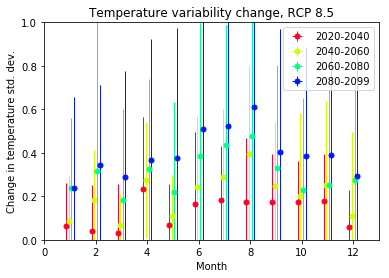

In [3]:
# look at monthly temperature variability

import matplotlib.pyplot as plt
import numpy
import ni_nileUtils
from cycler import cycler
%matplotlib inline

[tempHistorical, models] = ni_nileUtils.readModelData('data/r1-temp-historical.csv')
[tempRcp85, models] = ni_nileUtils.readModelData('data/r1-temp-rcp85.csv')

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

futurePeriods = [[2020, 2040], [2040, 2060], [2060, 2080], [2080, 2099]]
offsets = [-.15, -.05, .05, .15]

colormap = plt.get_cmap('gist_rainbow')
fig = plt.figure(0)
ax = fig.add_subplot(111)
ax.set_prop_cycle(cycler('color', [colormap(1.*i/4) for i in range(4)]) +
                   cycler('lw', [1, 2, 3, 4]))

legendList = []

for month in months:
    for f in range(len(futurePeriods)):
        futurePeriod = futurePeriods[f]
        
        # get indices of all days in this month
        indHistorical = numpy.where(tempHistorical['Month'] == month)
        # current month in the selected future time period
        indRcp85 = numpy.where((tempRcp85['Month'] == month) & (tempRcp85['Year'] > futurePeriod[0]) & (tempRcp85['Year'] < futurePeriod[1]))

        curMonthFuture = []
        curMonthHistorical = []
        curMonthStdChg = []

        # loop over all models
        for model in models:
            # get all years for current month in this model in past and future
            curMonthHistorical.append(tempHistorical[model][indHistorical])
            curMonthFuture.append(tempRcp85[model][indRcp85])

            # take difference in std. across all years in this month in future-past
            curMonthStdChg.append(numpy.std(curMonthFuture) - numpy.std(curMonthHistorical))

        yerr = (max(curMonthStdChg)-min(curMonthStdChg)/2.0)
        p = plt.errorbar(month + offsets[f], numpy.nanmean(curMonthStdChg), yerr, 0, fmt='o', elinewidth=1, markersize=5)
        if month == 1:
            legendList.append(p)

print(curMonthStdChg)
plt.ylim([0, 1])
plt.xlim([0, 13])
plt.xlabel('Month')
plt.ylabel('Change in temperature std. dev.')
plt.title('Temperature variability change, RCP 8.5')
plt.legend(legendList, ['2020-2040', '2040-2060', '2060-2080', '2080-2099'])
plt.savefig('variability-chg.png', dpi=600)
    

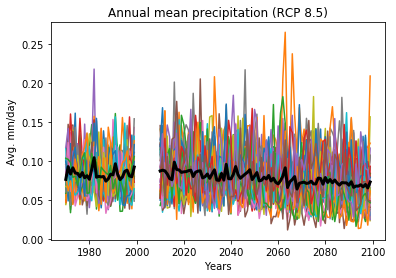

In [207]:
# annual mean precipitaton change

import matplotlib.pyplot as plt
from cycler import cycler
%matplotlib inline

[prHistorical, models] = readModelData('data/r1-pr-historical.csv')
[prRcp85, models] = readModelData('data/r1-pr-rcp85.csv')

plotAnnualMean(prHistorical, 'PR')
plotAnnualMean(prRcp85, 'Annual mean precipitation (RCP 8.5)')
plt.ylabel('Avg. mm/day')

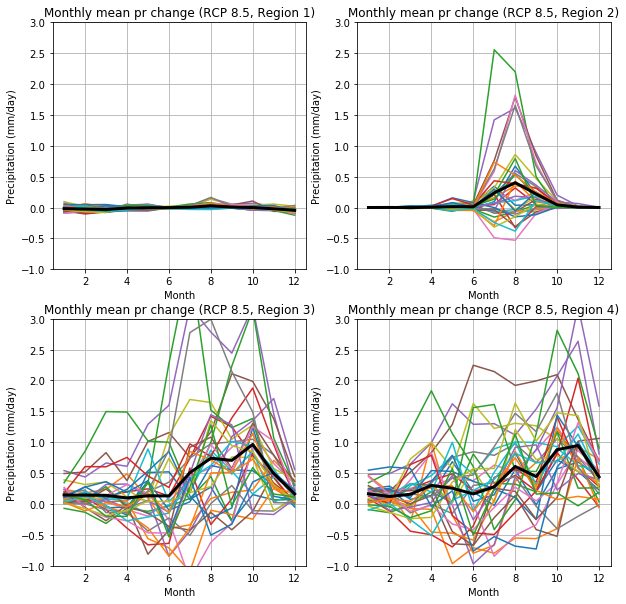

In [5]:
# plot seasonal precip change

import matplotlib.pyplot as plt
import ni_nileUtils
import numpy
%matplotlib inline

plt.figure(0,figsize=(10,10))

for region in [1,2,3,4]:
    [prHistorical, models] = ni_nileUtils.readModelData('data/r' + str(region) + '-pr-historical.csv')
    [prRcp85, models] = ni_nileUtils.readModelData('data/r' + str(region) + '-pr-rcp85.csv')

    months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    futurePeriod = [2060, 2090]

    monthlyMeanChg = []

    for month in months:
        # get indices of all days in this month
        indHistorical = numpy.where(prHistorical['Month'] == month)
        # current month in the selected future time period
        indRcp85 = numpy.where((prRcp85['Month'] == month) & (prRcp85['Year'] > futurePeriod[0]) & (prRcp85['Year'] < futurePeriod[1]))

        curMonthChg = []

        # loop over all models
        for model in models:
            curMonthChg.append(numpy.nanmean(prRcp85[model][indRcp85]) - numpy.nanmean(prHistorical[model][indHistorical]))

        monthlyMeanChg.append(curMonthChg)

    plt.subplot(2,2,region)
    plt.grid()
    plt.plot(months, monthlyMeanChg)
    plt.plot(months, numpy.nanmean(monthlyMeanChg, axis=1), 'k', linewidth = 3)
    plt.xlabel('Month')
    plt.ylabel('Precipitation (mm/day)')
    plt.ylim([-1, 3])
    plt.title('Monthly mean pr change (RCP 8.5, Region ' + str(region) +')')
plt.savefig('monthly-pr-chg.png', dpi=200)

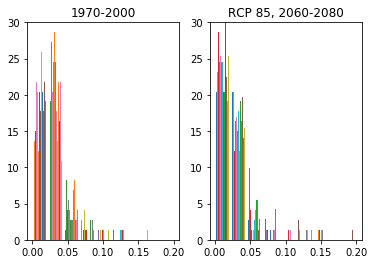

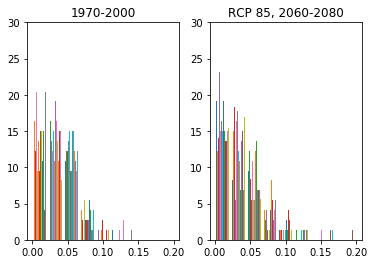

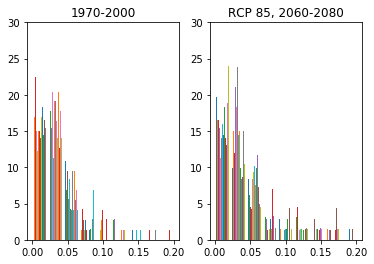

In [73]:
# plot change in each rainy season change

import matplotlib.pyplot as plt
from ni_nileUtils import *
%matplotlib inline

[prHistorical, models] = readModelData('data/r1-pr-historical.csv')
[prRcp85, models] = readModelData('data/r1-pr-rcp85.csv')

months = [6, 7, 8]

futurePeriod = [2060, 2080]

base = []
future = []

# loop over all models
for model in models:
    
    curBase = []
    curFuture = []
    
    for month in months:
        # get indices of all days in this month
        indHistorical = numpy.where(prHistorical['Month'] == month)
        # current month in the selected future time period
        indRcp85 = numpy.where((prRcp85['Month'] == month) & (prRcp85['Year'] > futurePeriod[0]) & (prRcp85['Year'] < futurePeriod[1]))

        # add all data for current month
        curBase.append(prHistorical[model][indHistorical])
        curFuture.append(prRcp85[model][indRcp85])
        
    base.append(curBase)
    future.append(curFuture)

base = numpy.array(base)
future = numpy.array(future)

bins = numpy.linspace(0,0.2,10)
plt.figure(0)
plt.subplot(1,2,1)
plt.hist(base[:,0], bins=bins, normed=True)
plt.title('1970-2000')
plt.ylim([0,30]);
plt.subplot(1,2,2)
plt.hist(future[:,0], bins=bins, normed=True)
plt.title('RCP 85, 2060-2080')
plt.ylim([0,30]);

plt.figure(1)
plt.subplot(1,2,1)
plt.hist(base[:,1], bins=bins, normed=True)
plt.title('1970-2000')
plt.ylim([0,30]);
plt.subplot(1,2,2)
plt.hist(future[:,1], bins=bins, normed=True)
plt.title('RCP 85, 2060-2080')
plt.ylim([0,30]);

plt.figure(2)
plt.subplot(1,2,1)
plt.hist(base[:,2], bins=bins, normed=True)
plt.title('1970-2000')
plt.ylim([0,30]);
plt.subplot(1,2,2)
plt.hist(future[:,2], bins=bins, normed=True)
plt.title('RCP 85, 2060-2080')
plt.ylim([0,30]);

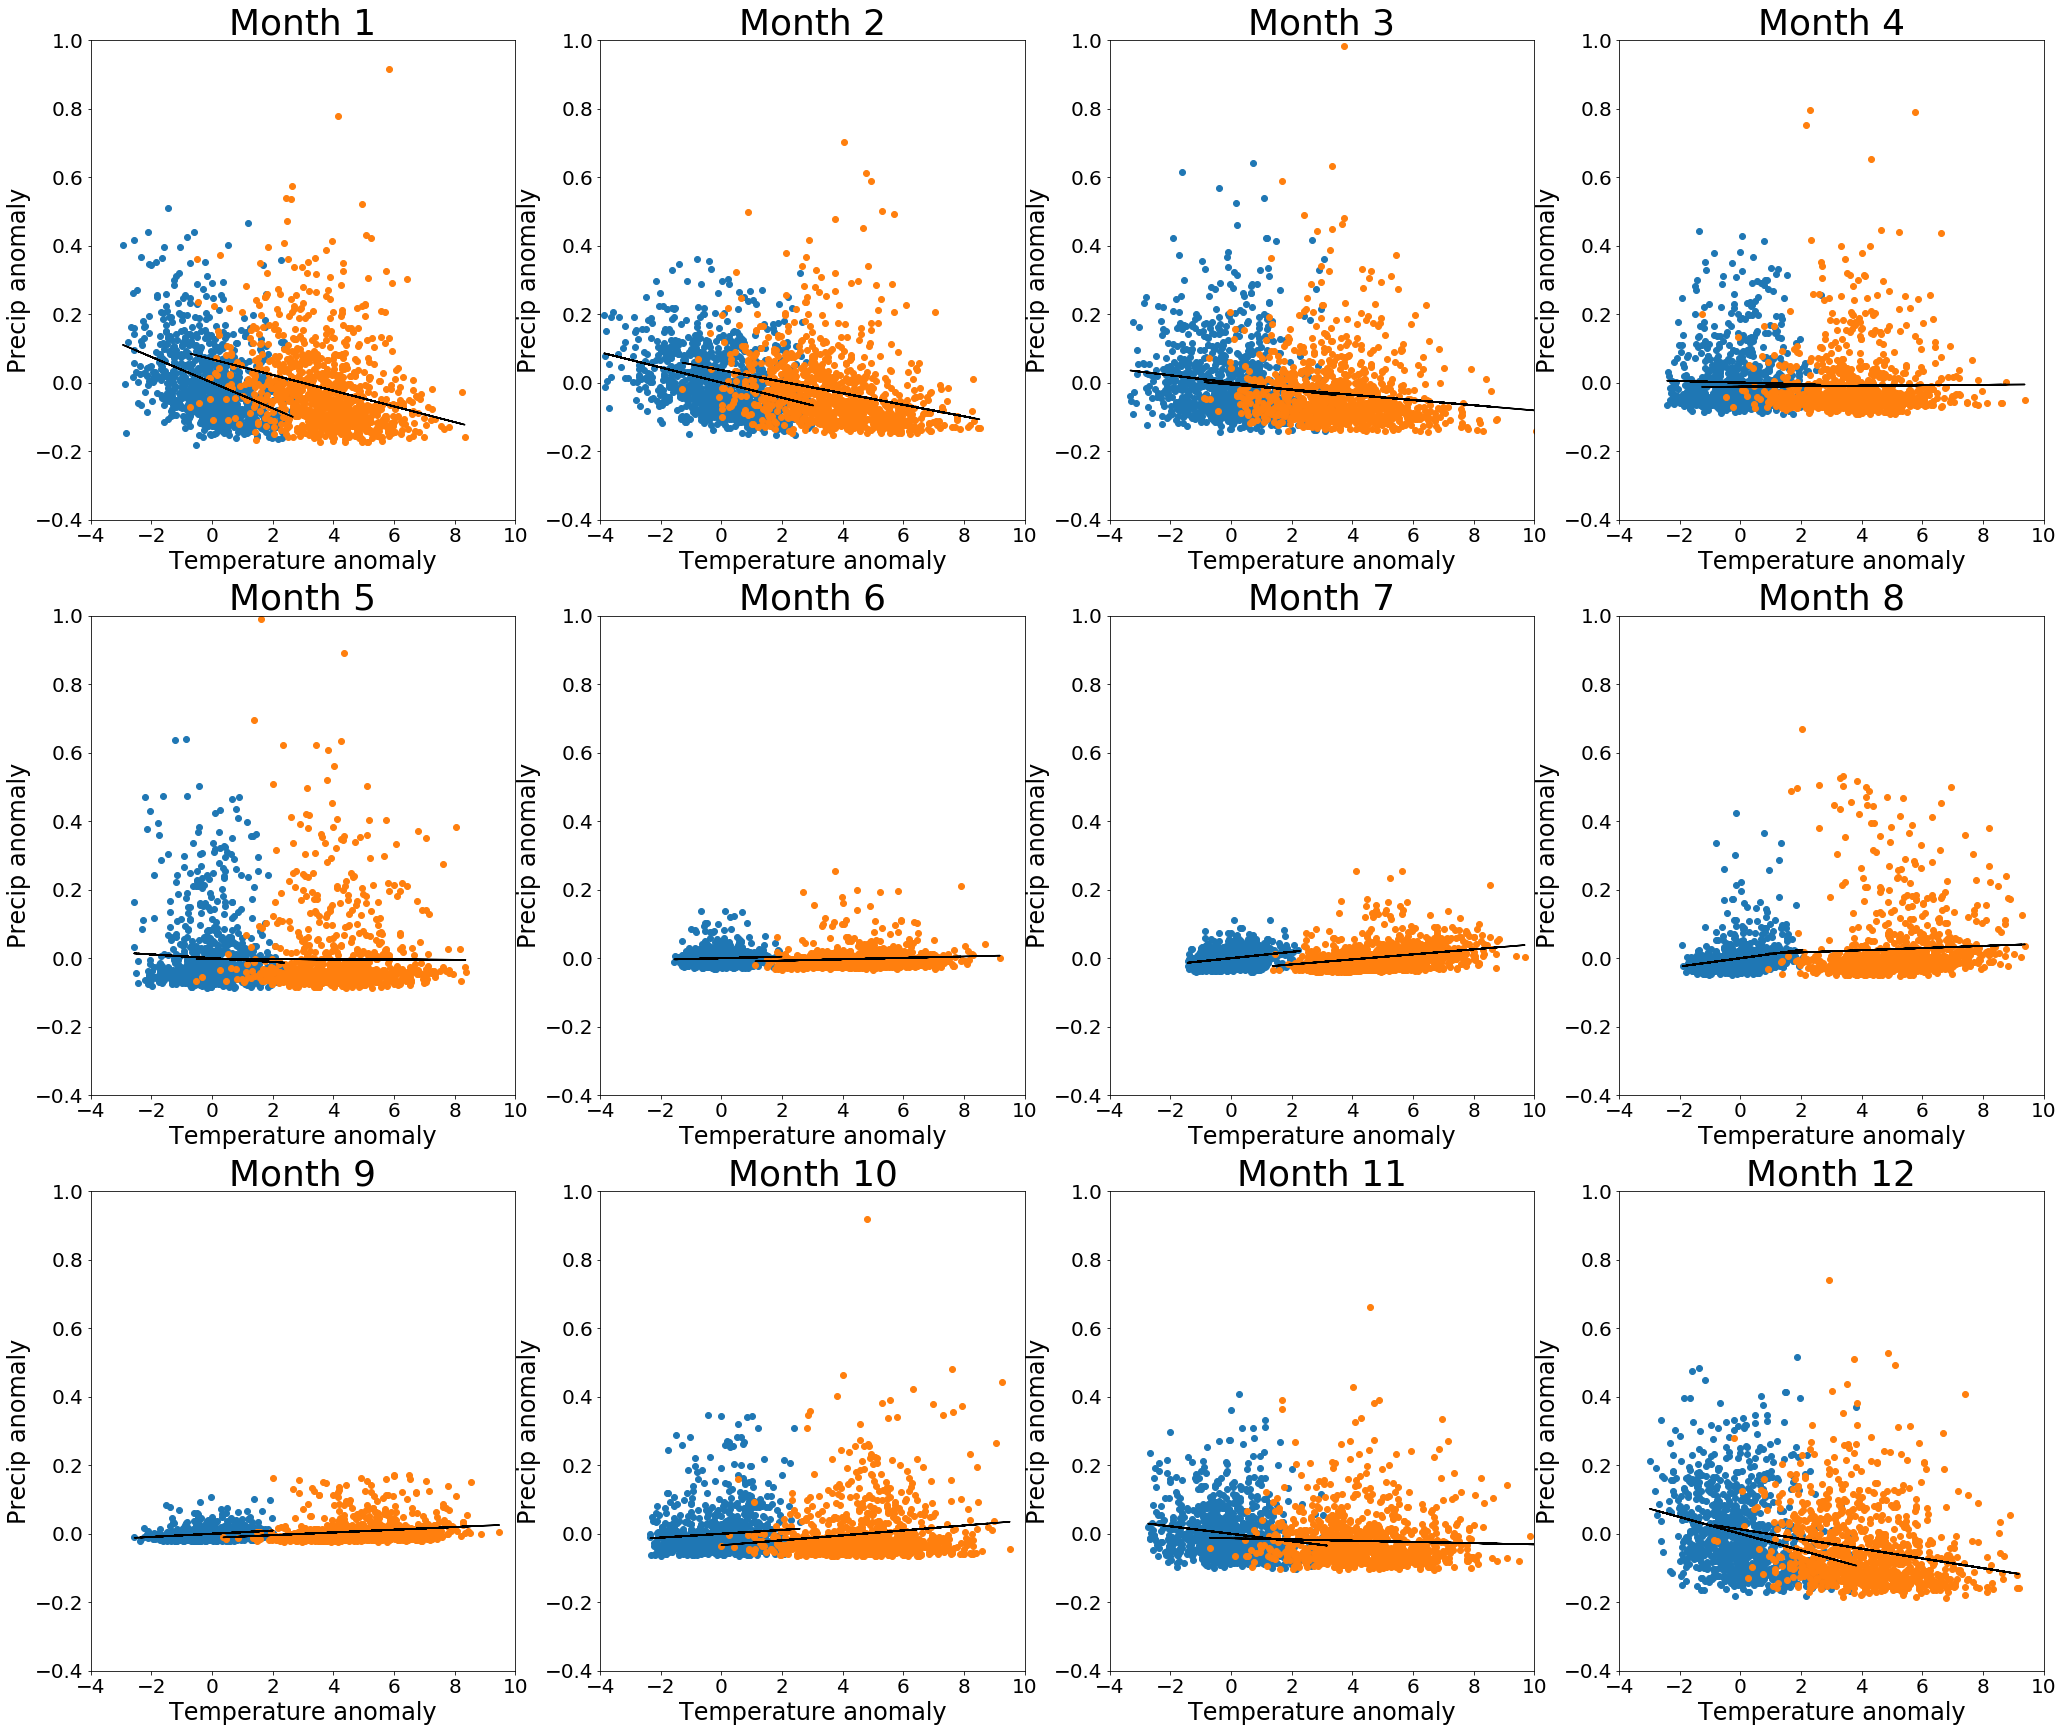

In [289]:
# gather temp/precip anomaly for each month

import matplotlib.pyplot as plt
%matplotlib inline

[prHistorical, models] = readModelData('data/r1-pr-historical.csv')
[tempHistorical, models] = readModelData('data/r1-temp-historical.csv')
[prRcp85, models] = readModelData('data/r1-pr-rcp85.csv')
[tempRcp85, models] = readModelData('data/r1-temp-rcp85.csv')

# monthly anomaly for each historical month/model in each year
historicalTempAnom = []
historicalPrAnom = []
rcp85TempAnom = []
rcp85PrAnom = []

months = list(range(1, 13))

futurePeriod = [2060, 2090]

# find historical monthly means
for month in months:
    # indices for this month
    indTempHistorical = numpy.where(tempHistorical['Month'] == month)
    indPrHistorical = numpy.where(prHistorical['Month'] == month)
    indTempRcp85 = numpy.where((tempRcp85['Month'] == month) & (tempRcp85['Year'] > futurePeriod[0]) & (tempRcp85['Year'] <= futurePeriod[1]))
    indPrRcp85 = numpy.where((prRcp85['Month'] == month) & (tempRcp85['Year'] > futurePeriod[0]) & (tempRcp85['Year'] <= futurePeriod[1]))
    
    # monthly means for all models in current month
    curHistoricalTempMeans = []
    curHistoricalPrMeans = []
    
    # monthly anomalies in past and future
    curHistoricalPrAnoms = []
    curHistoricalTempAnoms = []
    curRcp85PrAnoms = []
    curRcp85TempAnoms = []
    
    for model in models:
        if model == 'Actual': continue
            
        # calculate the historical monthly mean for this model
        meanTemp = numpy.nanmean(tempHistorical[model][indTempHistorical])
        meanPr = numpy.nanmean(prHistorical[model][indPrHistorical])
        
        # save
        curHistoricalTempMeans.append(meanTemp)
        curHistoricalPrMeans.append(meanPr)
        
        # now calculate monthly anomalies
        curHistoricalTempAnoms.append([x - meanTemp for x in tempHistorical[model][indTempHistorical]])
        curHistoricalPrAnoms.append([x - meanPr for x in prHistorical[model][indPrHistorical]])
        
        # and for the future
        curRcp85TempAnoms.append([x - meanTemp for x in tempRcp85[model][indTempRcp85]])
        curRcp85PrAnoms.append([x - meanPr for x in prRcp85[model][indPrRcp85]])
        
    historicalTempAnom.append(curHistoricalTempAnoms)
    historicalPrAnom.append(curHistoricalPrAnoms)
    rcp85TempAnom.append(curRcp85TempAnoms)
    rcp85PrAnom.append(curRcp85PrAnoms)

historicalTempAnom = numpy.array(historicalTempAnom)
historicalPrAnom = numpy.array(historicalPrAnom)
rcp85TempAnom = numpy.array(rcp85TempAnom)
rcp85PrAnom = numpy.array(rcp85PrAnom)

shouldPlot = True

if shouldPlot:
    plt.figure(figsize=(35,30))
    for month in list(range(0,12)):
        plt.subplot(3, 4, month+1)
        plt.scatter(historicalTempAnom[month, :, :], historicalPrAnom[month, :, :])
        plt.plot(historicalTempAnom[month, :, :].ravel(), numpy.poly1d(numpy.polyfit(historicalTempAnom[month, :, :].ravel(), historicalPrAnom[month, :, :].ravel(), 1))(historicalTempAnom[month, :, :].ravel()), color='k')

        plt.scatter(rcp85TempAnom[month, :, :], rcp85PrAnom[month, :, :])
        plt.plot(rcp85TempAnom[month, :, :].ravel(), numpy.poly1d(numpy.polyfit(rcp85TempAnom[month, :, :].ravel(), rcp85PrAnom[month, :, :].ravel(), 1))(rcp85TempAnom[month, :, :].ravel()), color='k')
        
        plt.title('Month ' + str(month+1), fontsize = 36)
        plt.xlim([-4, 10])
        plt.ylim([-0.4, 1])
        plt.xlabel('Temperature anomaly', fontsize = 24)
        plt.ylabel('Precip anomaly', fontsize = 24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

    #plt.savefig('monthly-anomalies.png', dpi=600)


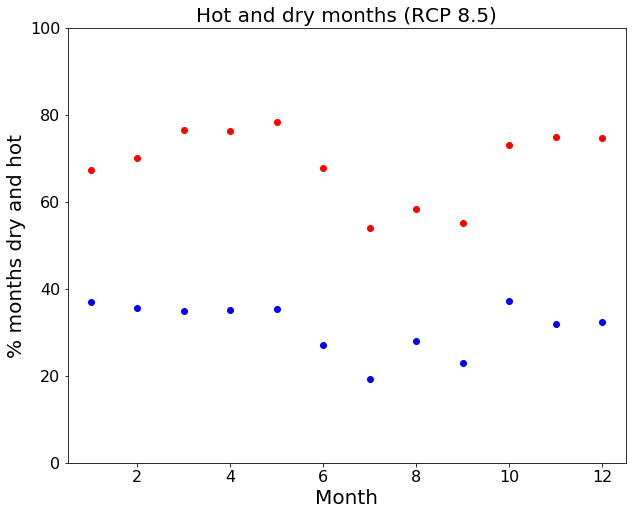

In [302]:
plt.figure(figsize=(10,8))
for month in range(12):
    tempHistorical = historicalTempAnom[month, :, :].ravel()
    prHistorical = historicalPrAnom[month, :, :].ravel()

    tempRcp85 = rcp85TempAnom[month, :, :].ravel()
    prRcp85 = rcp85PrAnom[month, :, :].ravel()
    
    indHistorical = numpy.where((tempHistorical > 0) & (prHistorical < 0))
    indRcp85 = numpy.where((tempRcp85 > 0) & (prRcp85 < 0))
    
    prcHist = numpy.size(indHistorical)/float(numpy.size(tempHistorical)) * 100
    prcRcp85 = numpy.size(indRcp85)/float(numpy.size(tempRcp85)) * 100
    
    plt.plot(month+1, prcHist, 'bo')
    plt.plot(month+1, prcRcp85, 'ro')
    
plt.xlim([0.5, 12.5])
plt.ylim([0, 100])
plt.xlabel('Month', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('% months dry and hot', fontsize=20)
plt.yticks(fontsize=16)
plt.title('Hot and dry months (RCP 8.5)', fontsize=20)
plt.savefig('hot-dry.png',dpi=600)
        
